22nd Dec

This notebook trains on:

  - med_res_3.zip (222 images)

  - comp1.zip (705 images)


# Prep

This blocks installs all the neccesary dependancies, and imports the relevant files

* import tf.models
* install relevant packages 
* import standard dataset
* import additional dataset
* define helper functions


In [1]:
!pip -q install tf_slim
!pip -q install pycocotools
!pip install -q -U tensorflow-addons

# !pip install -q -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 358kB 16.2MB/s 
     |████████████████████████████████| 706kB 16.6MB/s 


In [2]:
import tensorflow
print(tensorflow.__version__)

2.4.0


In [3]:
# Import tensorflow.models into the current directory
import os 
import pathlib
import sys

from tqdm.notebook import tqdm

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('...')
elif not pathlib.Path('models').exists():
  print('Downloading from github ... ')
  !git clone --depth 1 https://github.com/tensorflow/models

os.environ['PYTHONPATH'] += ":/content/models"
sys.path.append("/content/models")

Cloning into 'models'...
remote: Enumerating objects: 2393, done.
remote: Counting objects: 100% (2393/2393), done.
remote: Compressing objects: 100% (1995/1995), done.
remote: Total 2393 (delta 564), reused 1384 (delta 371), pack-reused 0
Receiving objects: 100% (2393/2393), 30.77 MiB | 38.14 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [5]:
%%bash 
cd models/research
pip -q install .

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
# Download data from drive into cwd

if 'Data' not in os.listdir():
  !cp "/content/drive/MyDrive/waste_detection/Data/med_res_3.zip" .
  !unzip -q med_res_3.zip -d Data
  # Remove the zip file 
  !rm med_res_3.zip

In [ ]:
if 'Comp_data' not in os.listdir():
  !cp "/content/drive/MyDrive/waste_detection/Data/comp1.zip" .
  !unzip -q comp1.zip -d comp_data
  # Remove the zip file 
  !rm comp1.zip

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import json
import random
import re
import io
import imageio
import cv2
import glob
import scipy.misc
import math
import numpy as np
import tensorflow_addons as tfa
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline


/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
# Helper functions 
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load images into numpy arrays 
def image_to_np(dir, w, h):
  output = [None] * len(os.listdir(dir))
  i = 0
  for file in tqdm(os.listdir(dir)):
    img = load_image_into_numpy_array(dir + file)
    res = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    output[i] = res
    i += 1
  return output

# Utilizes the visualization_utils
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold = 0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  
def split_data(SOURCE, TRAIN_DIR, TEST_DIR, SPLIT_PERCENT, seed = False, FILENAMES=None):

  # Get a list of image names

  if FILENAMES == None:
    files = []
    for filename in os.listdir(SOURCE):
        filepath = SOURCE + filename
        if filepath.endswith('.jpg'):
            files.append(filename)
  else:
    files = FILENAMES

  # Define test and train length
  train_length = int(len(files) * SPLIT_PERCENT)
  test_length = int(len(files)-train_length)

  # Shuffle and split
  if not seed:
    random.seed(1)
    random.shuffle(files)
    training_set = files[0:train_length]
    testing_set = files[-test_length:]
  else:
    training_set = []
    testing_set = []
    for filename in files:
      if filename in seed:
        testing_set.append(filename)
      elif filename not in seed:
        training_set.append(filename)

  # move the files
  for filename in training_set:
      os.replace(SOURCE+filename, TRAIN_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TRAIN_DIR+filename)
  for filename in testing_set:
      os.replace(SOURCE+filename, TEST_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TEST_DIR+filename)


# Move
This block moves the images in place and stores the data in memory

* split images into train and test folders
* all json files are stored in the same folder
* normalize boxes
* store all images as numpy arrays into memory
* convert np arrays into tensors, to be passed into model

In [ ]:
# Split data into train and test folders

def extract(label, category):
  if label[category] is not None:
    return np.array(label[category])

def get_valid_jpgs(classes, image_path, label_path):
  '''
    Returns a list of valid jpg paths that contain the given classes
  '''
  valid_jpgs = []
  no_annotations = 0

  # Select only samples that contain classes from above:
  for filepath in os.listdir(image_path):
    filename = filepath.split('/')[-1]
    if filename.endswith('.jpg'):
      json_file = os.path.join(label_path, filename[:-4]+'_bboxs.json')
      try:
        with open(json_file, 'r') as file:
          annotation = json.load(file)
          filtered_annotation = np.array([extract(annotation, classes[i]) for i in classes])
          for Class in filtered_annotation:
            # Only append if not empty
            if Class is not None:
              valid_jpgs.append(filename)
              break
      except:
        no_annotations += 1
        pass
  print(f'Total number of images:    {len(os.listdir(image_path))}')
  print(f'Images containing classes: {len(valid_jpgs)}')
  print(f'Found {no_annotations} images with no annotations')

  return valid_jpgs

  # def get_distribution_from_folder(classes, image_path, label_path):
  #   distribution = dict()
  #   for i in classes:
  #     Class = classes[i]
  #     distribution[Class] = 0

In [ ]:
# bagged_waste
# black_bag_waste
# fridge_or_freezer
# gas_bottle_or_cylinder_and_fire_extinguisher
# mattress
# sofa_or_settee_and_chair
# tv_monitor_and_laptop
# tyre_and_machine_track
# WEEE_large
# skip

all_classes = {1: 'bagged_waste',
               2: 'black_bag_waste',
               3: 'fridge_or_freezer',
               4: 'gas_bottle_or_cylinder_and_fire_extinguisher',
               5: 'mattress',
               6: 'sofa_or_settee_and_chair', 
               7: 'tv_monitor_and_laptop',
               8: 'tyre_and_machine_track',
               9: 'WEEE_large'}

current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'Data/images')
label_path = os.path.join(current_dir, 'Data/bboxes')

comp_image_path = os.path.join(current_dir, 'comp_data/images')
comp_label_path = os.path.join(current_dir, 'comp_data/bboxes')

selected_classes = {1: 'bagged_waste',
                    2: 'black_bag_waste',
                    3: 'mattress',
                    4: 'tyre_and_machine_track'}

category_index = {}
for i in selected_classes:
  category_index[i] = {'id': i, 'name': selected_classes[i]}

In [ ]:
print('ALL CLASSES \n-----------------')
get_valid_jpgs(all_classes, image_path, label_path)
get_valid_jpgs(all_classes, comp_image_path, comp_label_path)

print('\n')
print('SELECTED CLASSES \n-----------------')
valid_jpgs = get_valid_jpgs(selected_classes, image_path, label_path)
valid_jpgs_comp = get_valid_jpgs(selected_classes, comp_image_path, comp_label_path)

ALL CLASSES 
-----------------
Total number of images:    222
Images containing classes: 199
Found 0 images with no annotations
Total number of images:    705
Images containing classes: 369
Found 174 images with no annotations


SELECTED CLASSES 
-----------------
Total number of images:    222
Images containing classes: 178
Found 0 images with no annotations
Total number of images:    705
Images containing classes: 354
Found 174 images with no annotations


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
try: 
  os.mkdir(current_dir + '/working_data')
  os.mkdir(current_dir + '/working_data/train')
  os.mkdir(current_dir + '/working_data/test')
  print('Created train and test directories')
except:
  pass


working_dir = os.path.join(current_dir, 'working_data')
train_dir = os.path.join(working_dir, 'train/')
test_dir = os.path.join(working_dir, 'test/')

test_images = []
with open('Data/test_set.txt') as seed:
  for line in seed:
    test_images.append(line.split('\n')[0])

# Execute moving files
try:
  split_data(image_path+'/', train_dir, test_dir, 0.9, seed=test_images, FILENAMES=valid_jpgs)
except OSError:
  print('error raised')
  pass

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

Created train and test directories
train folder: 158, test folder: 20


In [ ]:
try:
  split_data(comp_image_path+'/', train_dir, test_dir, 1, FILENAMES=valid_jpgs_comp)
except OSError:
  print('error raised')
  pass

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

error raised
train folder: 512, test folder: 20


In [ ]:
# Move annotation files into the same folder
try:
  os.mkdir(working_dir + '/annotations')
except:
  pass

annotation_dir = working_dir + '/annotations/'

for image in valid_jpgs:
  json_filename = image[:-4] + '_bboxs.json'
  json_file_path = label_path + '/' + json_filename
  shutil.copyfile(json_file_path, annotation_dir + json_filename)

for image in valid_jpgs_comp:
  json_filename = image[:-4] + '_bboxs.json'
  json_file_path = comp_label_path + '/' + json_filename
  shutil.copyfile(json_file_path, annotation_dir + json_filename)

print(len(os.listdir(annotation_dir)))


532


In [ ]:
# Load label json files into numpy arrays 

def json_to_np(dir):
  output_boxes = []
  output_classes = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(annotation_dir, file[:-4]+'_bboxs.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      categories = np.array([extract(label, selected_classes[i]) for i in selected_classes])

      boxes = np.array([[0, 0, 0, 0]])
      classes = np.array([])

      for index, category in enumerate(categories):
        if category is not None:
          boxes = np.vstack([boxes, category])
          classes = np.append(classes, np.array([int(index+1)]*len(category)))
    
      output_boxes.append(boxes[1:].astype('float'))
      output_classes.append(classes.astype('int32'))

  return output_boxes, output_classes


y_train_boxes, y_train_classes = json_to_np(train_dir)
y_test_boxes, y_test_classes = json_to_np(test_dir)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [ ]:
# Normalize the labels 

# width: 420, height: 312
# Data format right now: [xmin, ymin, xmax, ymax]
# Target format         : [ymin, xmin, ymax, xmax]

orig_width = 640
orig_height = 640

target_width = orig_width
target_height = orig_height

def normalize_boxes(labels):
  for label in labels:
    for box in label:
      box[0], box[1], box[2], box[3] = box[1], box[0], box[3], box[2]
  return labels

y_train_boxes = normalize_boxes(y_train_boxes)
y_test_boxes = normalize_boxes(y_test_boxes)

print(y_test_boxes[0])

[[0.458333 0.14199  0.677885 0.299758]
 [0.456731 0.400485 0.626603 0.531553]
 [0.419872 0.667475 0.559295 0.788834]
 [0.528846 0.834952 0.625    0.916262]
 [0.100962 0.401699 0.233975 0.479369]
 [0.222756 0.538834 0.334935 0.667475]
 [0.141025 0.271844 0.251603 0.406553]
 [0.472756 0.001214 0.698718 0.166263]
 [0.689103 0.082524 0.826924 0.296116]
 [0.307693 0.466019 0.532052 0.678399]
 [0.161859 0.765777 0.371795 0.993931]
 [0.120193 0.5      0.213142 0.612864]]


In [ ]:
x_train_np = image_to_np(train_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_train_np)} training images')

x_test_np = image_to_np(test_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_test_np)} training images')




 Appended and resized 512 training images




 Appended and resized 20 training images


In [ ]:
# Merge Classes + distribution Summary

distribution_train = {}
distribution_test = {}
distribution_test_trivial = {}

for i in selected_classes:
  distribution_train[selected_classes[i]] = 0
  distribution_test[selected_classes[i]] = 0
  distribution_test_trivial[selected_classes[i]] = 0

for annotation in y_train_classes:
  for j, Class in enumerate(annotation):
    distribution_train[selected_classes[annotation[j]]] += 1

for annotation in y_test_classes:
  for j, Class in enumerate(annotation):
    distribution_test[selected_classes[annotation[j]]] += 1

print('Train Set')
print(distribution_train)
print('\nTest set')
print(distribution_test)

Train Set
{'bagged_waste': 727, 'black_bag_waste': 1185, 'mattress': 101, 'tyre_and_machine_track': 240}

Test set
{'bagged_waste': 34, 'black_bag_waste': 134, 'mattress': 6, 'tyre_and_machine_track': 7}


## np_to_tensors()




In [ ]:
# Prepping data, converting np arrays into tensors 

num_classes = 4

def np_to_tensors(image_nps, box_nps, class_nps):
  label_id_offset = 1

  image_tensors = []
  box_tensors = []
  classes_one_hot_tensors = []

  for (image_np, box_np, class_np) in zip(image_nps, box_nps, class_nps):
    image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        image_np, dtype=tf.float32), axis=0))
    
    box_tensors.append(tf.convert_to_tensor(box_np, dtype=tf.float32))
    
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=np.int32)
    classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

  return image_tensors, box_tensors, classes_one_hot_tensors

train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = np_to_tensors(x_train_np, y_train_boxes, y_train_classes)
test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors = np_to_tensors(x_test_np, y_test_boxes, y_test_classes)

print('Done prepping data.')

Done prepping data.


In [ ]:
# Optional: visulize images

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

plt.figure(figsize=(30, 15))
for i in range(6):
  offset = 2
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_train_np[i+ offset], dsize=(421, 320), interpolation=cv2.INTER_CUBIC),
      y_train_boxes[i+ offset],
      y_train_classes[i+ offset],
      np.ones(shape=[y_train_boxes[i+ offset].shape[0]], dtype=np.float16),
      category_index)
plt.axis('off')

plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Load Config

This block creates the model metaArch, and loads untrained weights

* download weights from tensorflow.models
* loads the config file from '/models/research/object_detection/configs'
* restores weights and create a checkpoint instance



In [ ]:
# if 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8' not in os.listdir():
#   !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz 
#   !tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
#   !rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
# !mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/


!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!rm ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-12-22 22:12:21--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.164.144, 2607:f8b0:4004:815::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.164.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   118MB/s    in 2.0s    

2020-12-22 22:12:23 (118 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
# Configuring and creating the detection model (weight's are not loaded here)

num_classes = 4
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt'

# # raw_checkpoint = checkpoint_path

# pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
# checkpoint_path = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt'

raw_checkpoint = checkpoint_path + '-0'


# Load pipeline config and build a detection model architecture (only need to be ran once)

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config = model_config, is_training=True
)


In [ ]:
# [i.name for i in detection_model.trainable_variables]
# # len(detection_model.trainable_variables)

In [ ]:
# Restore weights (original weights)

def restore_weights(ckpt_path, restore_all=True):

  print(f'restoring weights from {str(ckpt_path)}')

  if restore_all:
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(ckpt_path).expect_partial()
  
  else:
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
      _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
      _box_prediction_head=detection_model._box_predictor._box_prediction_head
      )

    fake_model = tf.compat.v2.train.Checkpoint(
                _feature_extractor=detection_model._feature_extractor,
                _box_predictor=fake_box_predictor)
  
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(ckpt_path).expect_partial()

  # Run model through a dummy image so that variables are created
  image, shapes = detection_model.preprocess(tf.zeros([1, target_height, target_width, 3]))
  prediction_dict = detection_model.predict(image, shapes)
  _ = detection_model.postprocess(prediction_dict, shapes)
  print('Weights restored!')

  return ckpt

# Initialize ckpt
ckpt = restore_weights(raw_checkpoint, restore_all=False)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0
Weights restored!


# Functions
This block contains the following functions:

* step function (for both training and evaluating)
* layer extraction function
* main training block (given hyperparameters)

### get_model_train_step_function()


In [ ]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    backprop = True):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      if backprop:
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss, detection_model.postprocess(prediction_dict, shapes)

  return train_step_fn

### get_variables()


In [ ]:
def get_variables(prefixes_to_train):
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  return to_fine_tune

### train()

In [ ]:
def train(epochs, 
          batch_size, 
          train_step_fn, 
          flip_prob = 0.2,
          rotate_prob = 0.2,
          hue_prob = 0.2, 
          crop_prob = 0.2):
  '''
    Performs training given epoch and batch size 

    Note: this function does not generalize, neither x_train_np or labels are passed
    as arguments
  '''

  tf.keras.backend.clear_session()

  num_batches = (len(x_train_np) // batch_size) + 1

  print('Started fine-tuning!', flush=True)

  cv_loss, cv_map = test_evaluate()

  print(f'Initial cv_loss: {cv_loss:.6f}, cv_map: {cv_map:.6f}')

  for e in range(epochs):

    epoch_loss = 0

    all_keys = list(range(len(x_train_np)))
    random.shuffle(all_keys)

    for i in tqdm(range(num_batches)):

      image_list, boxes_list, classes_list = [], [], []

      # Grab keys for a random subset of examples
      example_keys = all_keys[(i*batch_size):((i+1)*batch_size)]

      for key in example_keys:
        temp_image = x_train_np[key]
        temp_box = y_train_boxes[key]
        temp_class = y_train_classes[key]
        
        # Augmentation:
        temp_image, temp_box = random_horizontal_flip(temp_image, temp_box, flip_prob)
        temp_image, temp_box = random_rotate(temp_image, temp_box, rotate_prob)
        temp_image, temp_box = random_hue(temp_image, temp_box, hue_prob)
        temp_image, temp_box, temp_class = random_crop(temp_image, temp_box, temp_class, crop_prob)

        image_list.append(temp_image)
        boxes_list.append(temp_box)
        classes_list.append(temp_class)

      image_tensors, boxes_tensors, classes_tensors = np_to_tensors(image_list, boxes_list, classes_list)

      # Training step (forward pass + backwards pass)
      total_loss, _ = train_step_fn(image_tensors, boxes_tensors, classes_tensors)

      epoch_loss += total_loss.numpy()

    epoch_loss /= num_batches

    cv_loss, cv_map = test_evaluate()
    print('epoch {} of {}, loss= {:.6}, cv_loss = {:.6}, cv_map = {:.6}'.format(e+1, epochs, epoch_loss, cv_loss, cv_map))

  print(f'final cv_loss: {cv_loss :.6}, cv_map: {cv_map :.6}')
  print('Done fine-tuning!')

### test_evaluate()

In [ ]:
def test_evaluate():
  batch_size = 5
  loss = 0
  num_batches = len(test_image_tensors) // batch_size
  # train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

  keys = list(range(len(x_test_np)))

  detected_boxes = []
  detected_classes = []
  detected_scores = []

  for i in range(num_batches):
    key_batch = keys[(i*batch_size):((i+1)*batch_size)]
    gt_boxes_list, gt_classes_list, image_tensors = [], [], []

    for key in key_batch:
      image_tensors.append(test_image_tensors[key])
      gt_boxes_list.append(test_gt_box_tensors[key])
      gt_classes_list.append(test_gt_classes_one_hot_tensors[key])

    batch_loss, detections = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list, backprop=False)

    for score, Class, box in zip(detections['detection_scores'], detections['detection_classes'], detections['detection_boxes']):
      detected_score, detected_class, detected_box = filter_from_score(score.numpy(),
                                                                      Class.numpy()+1,
                                                                      box.numpy(),
                                                                      threshold = 0.1)
      detected_boxes.append(detected_box)
      detected_classes.append(detected_class)
      detected_scores.append(detected_score)  

    loss += batch_loss

  _, _, maps = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5, 
                          suppress_output = True)
  
  map = sum(maps)/num_classes
  return loss.numpy()/num_batches, map

### random_hue()

In [ ]:
def random_hue(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.random_contrast(tf.image.random_hue(tf.image.random_brightness(image_np, 0.2), 0.1), 0.8, 1.2).numpy()
  return image_np, boxes

### random_horizontal_flip()

In [ ]:
# Flip box
def flip_box_left_right(boxes):
  tempboxes = boxes.copy()
  for i in range(len(tempboxes)):
    tempboxes[i][1], tempboxes[i][3] = 1 - tempboxes[i][3], 1 - tempboxes[i][1]
    # tempboxes[i][3] = 1 - tempboxes[i][1]
  
  return tempboxes

def random_horizontal_flip(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.flip_left_right(image_np).numpy()
    boxes = flip_box_left_right(boxes)
  return image_np, boxes

### random_rotate()

In [ ]:
def two_points_to_four_points(box):
  coord_1 = (box[0], box[1])
  coord_2 = (box[2], box[1])
  coord_3 = (box[2], box[3])
  coord_4 = (box[0], box[3])
  return([coord_1, coord_2, coord_3, coord_4])

def rotate_coordinates(boxes, alpha):
  output_boxes = []
  for j, box in enumerate(boxes):
    box = two_points_to_four_points(box)
    for i, coord in enumerate(box):
      x_rel = coord[0] - 0.5
      y_rel = 0.5 - coord[1]
      if -1e-6 < x_rel < 1e-6:
        x_rel = 1e-6
      r = ((x_rel)**2 + (y_rel)**2)**0.5
      theta = math.atan(y_rel/x_rel)
      if theta < 0:
        if y_rel > 0:
          theta += math.pi
      if theta > 0:
        if y_rel < 0:
          theta += math.pi

      new_coord = (r * math.cos(theta+alpha) + 0.5, 0.5 - r*math.sin(theta+alpha))
      box[i] = new_coord
    output_boxes.append(box)

  return output_boxes

def rotate_box(boxes, alpha):
  boxes = rotate_coordinates(boxes, alpha)
  output_boxes = np.array([0, 0, 0, 0])
  for box in boxes:
    xmin = min(coord[0] for coord in box)
    ymin = min(coord[1] for coord in box)
    xmax = max(coord[0] for coord in box)
    ymax = max(coord[1] for coord in box)

    if xmin < 0: 
      xmin = 0
    if xmax > 1:
      xmax = 1
    if ymin < 0:
      ymin = 0
    if ymax > 1:
      ymax = 1

    output_boxes = np.vstack([output_boxes, [xmin, ymin, xmax, ymax]])
  
  return output_boxes[1:]

def random_rotate(image_np, boxes, probability):

  if random.random() < probability:
    alpha = random.random() * math.pi/4 - math.pi/8
    image_np = tfa.image.rotate(image_np, alpha).numpy()
    boxes = rotate_box(boxes, -alpha)

  return image_np, boxes


### random_crop()

In [ ]:
# scaling: 

def random_crop(image_np, boxes, classes, probability):

  if random.random() < probability:
    width = image_np.shape[0]
    height = image_np.shape[1]

    crop_width = random.randint(math.floor(0.6 * width), math.floor(0.9*width))
    crop_height = random.randint(math.floor(0.6 * height), math.floor(0.9*height))

    offset_x = random.randint(0, width - crop_width)
    offset_y = random.randint(0, height - crop_height)

    image_np = tf.image.crop_to_bounding_box(image_np, offset_y, offset_x, crop_height, crop_width).numpy()

    temp_boxes = np.array([[0, 0, 0, 0]])
    temp_classes = np.array([]).astype('int')

    for box, Class in zip(boxes, classes):
      temp_box = np.array([0, 0, 0, 0]).astype('float16')

      area_before = ((box[3] - box[1]) * (box[2] - box[0])) * width * height

      temp_box[0], temp_box[2] = box[0] * height - offset_y, box[2] * height - offset_y
      temp_box[1], temp_box[3] = box[1] * width - offset_x, box[3] * width - offset_x

      temp_box[0], temp_box[2] = (temp_box[0]) / crop_height, (temp_box[2]) / crop_height
      temp_box[1], temp_box[3] = (temp_box[1]) / crop_width, (temp_box[3]) / crop_width

      if temp_box[0] < 0:
        temp_box[0] = 0
      if temp_box[1] < 0:
        temp_box[1] = 0
      if temp_box[2] > 1:
        temp_box[2] = 1
      if temp_box[3] > 1:
        temp_box[3] = 1

      area_after = ((temp_box[3] - temp_box[1]) * (temp_box[2] - temp_box[0])) * crop_width * crop_height
      
      if area_after > 0.5 * area_before:
        temp_boxes = np.vstack([temp_boxes, temp_box])
        temp_classes = np.append(temp_classes, Class)

      boxes = temp_boxes[1:]
      classes = temp_classes

  return image_np, boxes, classes


## mAP Block

In [ ]:
# Calculate IOU 
  # There is one IOU value per box (in prediction)
  # Match to Ground truth or none

# Ground truth boxes: m x 4 np array 
# Detection boxes: 1 x 100 x 4 tensor 

# [ymin, xmin, ymax, xmax]

# xi1 = maximum of the x1 coordinates of the two boxes
# yi1 = maximum of the y1 coordinates of the two boxes
# xi2 = minimum of the x2 coordinates of the two boxes
# yi2 = minimum of the y2 coordinates of the two boxes

def iou(box1, box2):
  """Implement the intersection over union (IoU) between box1 and box2
    
  Arguments:
  box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
  """

  # Assign variable names to coordinates for clarity
  (box1_y1, box1_x1, box1_y2, box1_x2) = box1
  (box2_y1, box2_x1, box2_y2, box2_x2) = box2
  
  # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2
  xi1 = np.maximum(box1_x1, box2_x1)
  yi1 = np.maximum(box1_y1, box2_y1)
  xi2 = np.minimum(box1_x2, box2_x2)
  yi2 = np.minimum(box1_y2, box2_y2)
  inter_width = yi2 - yi1
  inter_height = xi2 - xi1
  if inter_width < 0 or inter_height < 0:
      return 0
  inter_area = inter_width * inter_height

  # Calculate the Union area
  box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
  box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
  union_area = (box1_area + box2_area) - inter_area
  
  # compute the IoU
  iou = inter_area / union_area
  
  return iou

def filter_from_score(scores, classes, boxes, threshold):
  for i, score in enumerate(scores):
    if score < threshold:
      break
  return scores[:i], classes[:i], boxes[:i]

def get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes):

  '''
    Arguments:
    detected_boxes: (m x 4) for each image
    detected_classes: (m x 1) for each image

    gt_boxes: (n x 4)
    gt_classes: (n x 1)
  
    Output:
    iou_arr: (m x 4), maximum iou for each detection
    detected_which: (m x 4) index to detection
  '''

  ious_arr = [0] * len(detected_boxes)
  detected_which = [-1] * len(detected_boxes)
  hash_table = [None] * len(gt_boxes)

  # edge case: no detections or no ground truth boxes
  if len(detected_boxes) == 0:
    return [], []

  if len(gt_boxes) == 0:
    # print(f'no objects, {len(detected_boxes)} detections all wrong')
    return [0] * len(detected_boxes), [-1] * len(detected_boxes)

  for idx_detection, (box, label) in enumerate(zip(detected_boxes, detected_classes)):
    max_iou = 0
    # assume no detection
    for idx_gt, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
      if gt_class == label:
        iou_val = iou(gt_box, box)
        if iou_val > max_iou:
          max_iou = iou_val
          detected_which[idx_detection] = idx_gt
    
    detected_gt = detected_which[idx_detection]
    if not hash_table[detected_gt]:
      # print(detected_gt)
      hash_table[detected_gt] = (max_iou, idx_detection)
    else:
      # compare iou, if larger than existing assigned value for a gt box:
      if hash_table[detected_gt][0] < max_iou:
        # change detected_gt for the box currently assigned in the slot
        # print(f'need to delete {hash_table[detected_gt][1]}, which is currently {detected_which[hash_table[detected_gt][1]]}, replacing with {idx_detection}')
        detected_which[hash_table[detected_gt][1]] = -1
        # print(f'now it should be {detected_which[hash_table[detected_gt][1]]}')
        # change hash table value
        hash_table[detected_gt] = (max_iou, idx_detection)
      elif hash_table[detected_gt][0] > max_iou:
        # this detection is worse than previous ones, hence a false positive
        detected_which[idx_detection] = -1       
    ious_arr[idx_detection] = max_iou

  # print(f'{len(detected_boxes)} detections')
  # print(f'detected_which: {detected_which}')
  # print(f'hash table: {hash_table}')
  return ious_arr, detected_which

def get_tpfp(ious_arr, detected_which, iou_threshold = 0.5):
  tpfp = []
  for which, iou_val in zip(detected_which, ious_arr):
    if which < 0 or iou_val < iou_threshold:
      tpfp.append(0)
    else:
      tpfp.append(1) 
  
  return tpfp

def get_tpfp_list(detected_box_list, detected_class_list, detected_score_list, gt_box_list, gt_class_list, iou_threshold):
  '''
    Categorizes detections into a list of true positives and false positives in descending order of confidence level
  '''
  tpfp_list = []

  for idx in range(len(detected_score_list)):
    detected_boxes, detected_classes, detected_scores = detected_box_list[idx], detected_class_list[idx], detected_score_list[idx]

    gt_boxes = gt_box_list[idx]
    gt_classes = gt_class_list[idx]

    ious_arr, detected_which = get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes)

    tpfp = get_tpfp(ious_arr, detected_which, iou_threshold=iou_threshold)

    tpfp_score_pairs = [(i, j) for i, j in zip(tpfp, detected_scores)]

    tpfp_list += tpfp_score_pairs
  
  # print(f'tpfp_list: {tpfp_list}')
  return tpfp_list

def calculate_map(detected_box_list, 
                  detected_class_list, 
                  detected_score_list, 
                  gt_box_list, 
                  gt_class_list, 
                  num_of_classes,
                  iou_threshold = 0.5, 
                  suppress_output = True):
  '''
    calculates mAP, outputs precision and recall

    Inputs are filtered lists of detection boxes, classes, and confidence scores
    Detections have to be preprocessed and filtered based on confidence threshold

    detected_box_list: m x ? x 4
    detected_class_list: m x ?
    detected_score_list: m x ?

    gt_box_list: m x ?
    gt_class_list: m x ?

    where m is the number of samples
    ? because the number of detections and number of gt boxes is different for each sample
    all lists are lists of np arrays
  '''

  precision_list = []
  recall_list = []
  map_list = []

  for c in range(num_of_classes):

    class_eval = c + 1
    length = len(detected_box_list)
    detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    detected_classes_eval = [np.array([])]*length
    detected_scores_eval = [np.array([])]*length

    length = len(gt_class_list)
    gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    gt_classes_eval = [np.array([])]*length


    for i, detected_class in enumerate(detected_class_list):
      for j, Class in enumerate(detected_class):
        if Class == class_eval:
          detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_class_list[i][j])
          detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_box_list[i][j]])
          detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_score_list[i][j])
      if detected_boxes_eval[i].shape[0] == 1:
        detected_boxes_eval[i] = np.array([])
      else:
        detected_boxes_eval[i] = detected_boxes_eval[i][1:]

    for i, gt_class in enumerate(gt_class_list):
      for j, Class in enumerate(gt_class):
        if Class == class_eval:
          gt_classes_eval[i] = np.append(gt_classes_eval[i], gt_class_list[i][j])
          gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], gt_box_list[i][j]])
      if gt_boxes_eval[i].shape[0] == 1:
        gt_boxes_eval[i] = np.array([])
      else:
        gt_boxes_eval[i] = gt_boxes_eval[i][1:]

    tpfp_list = get_tpfp_list(detected_boxes_eval, 
                              detected_classes_eval, 
                              detected_scores_eval, 
                              gt_boxes_eval, 
                              gt_classes_eval, 
                              iou_threshold=iou_threshold)
                              

    tpfp_list.sort(key=lambda tup: tup[1], reverse=True)
    # print(f'sorted tpfp: {tpfp_list}')

    precisions = []
    recalls = []
    tp = 0
    fp = 0

    total = 0
    for i in gt_boxes_eval:
      total += len(i)

    detection_total = 0
    for i in detected_boxes_eval:
      detection_total += len(i)

    for i, (tpfp, _) in enumerate(tpfp_list):
      if tpfp == 1:
        tp += 1
      else:
        fp += 1

      precision = tp/(tp+fp)
      if total > 0:
        recall = tp/total
      else:
        recall = 0

      precisions.append(precision)
      recalls.append(recall)
      
    if not suppress_output:
      print(f'{selected_classes[c+1]}: {total} annotations')
      print(f'{tp} / {detection_total} correct detections \n')
  
    map = np.trapz(precisions, recalls)
    precision_list.append(np.array(precisions))
    recall_list.append(np.array(recalls))
    map_list.append(map)

  return precision_list, recall_list, map_list

## Augmentation example

In [ ]:
# plt.rcParams['figure.figsize'] = [15, 10]

# idx = 8

# plt.subplot(1, 4, 1)
# plot_detections(
#       cv2.resize(x_train_np[idx], dsize=(421, 320), interpolation=cv2.INTER_CUBIC).astype('int'),
#       y_train_boxes[idx],
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# # alpha = -math.pi/4

# rotated_image, rotated_box = random_rotate(x_train_np[idx], y_train_boxes[idx], 1)

# plt.subplot(1, 4, 2)
# plot_detections(
#       rotated_image,
#       rotated_box,
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# flipped_image, flipped_box = random_horizontal_flip(rotated_image, rotated_box, 1)

# plt.subplot(1, 4, 3)

# plot_detections(
#       flipped_image,
#       flipped_box,
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# cropped_image, cropped_boxes, cropped_classes = random_crop(flipped_image, flipped_box, y_train_classes[idx], 1)

# plt.subplot(1, 4, 4)
# plot_detections(
#       cropped_image,
#       cropped_boxes,
#       cropped_classes,
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# Training Block

This block contains: 
* Training Top
* Training Middle
* Training Whole
* Save trained Model


## Save untuned


In [ ]:
untuned_checkpoint = ckpt.save(checkpoint_path+'-untuned') 

In [ ]:
# Optional - load
ckpt = restore_weights(untuned_checkpoint, restore_all = True)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-28
Weights restored!


## Top


### Hyperparameters


In [ ]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Hyper parameters
epochs = 10
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam()

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                              'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss, map = test_evaluate()
print(f'loss: {test_loss :.6}, map: {map :.6}')

# Untuned - 1.45610507329305

loss: 1.41007, map: 0.0


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 1.410067, cv_map: 0.000000



epoch 1 of 10, loss= 0.92205, cv_loss = 0.735655, cv_map = 0.152499



epoch 2 of 10, loss= 0.813976, cv_loss = 0.76692, cv_map = 0.179745



epoch 3 of 10, loss= 0.82617, cv_loss = 0.705051, cv_map = 0.133593



epoch 4 of 10, loss= 0.815048, cv_loss = 0.749983, cv_map = 0.186456



epoch 5 of 10, loss= 0.795149, cv_loss = 0.697761, cv_map = 0.231815



epoch 6 of 10, loss= 0.760737, cv_loss = 0.733295, cv_map = 0.161109



epoch 7 of 10, loss= 0.78059, cv_loss = 0.756721, cv_map = 0.132857



epoch 8 of 10, loss= 0.829397, cv_loss = 0.72687, cv_map = 0.143478



epoch 9 of 10, loss= 0.768865, cv_loss = 0.730702, cv_map = 0.150811



epoch 10 of 10, loss= 0.783684, cv_loss = 0.77493, cv_map = 0.14965
final cv_loss: 0.77493, cv_map: 0.14965
Done fine-tuning!


In [ ]:
train(5, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 0.774930, cv_map: 0.149650



epoch 1 of 5, loss= 0.765155, cv_loss = 0.709375, cv_map = 0.184436



epoch 2 of 5, loss= 0.758819, cv_loss = 0.731558, cv_map = 0.167012



epoch 3 of 5, loss= 0.74447, cv_loss = 0.744699, cv_map = 0.152476



epoch 4 of 5, loss= 0.748057, cv_loss = 0.717789, cv_map = 0.169877



epoch 5 of 5, loss= 0.753475, cv_loss = 0.713357, cv_map = 0.251314
final cv_loss: 0.713357, cv_map: 0.251314
Done fine-tuning!


### Save

In [ ]:
top_trained_checkpoint = ckpt.save(checkpoint_path+'-top')
# top_trained_checkpoint = checkpoint_path + '-top_trained-55'
print(top_trained_checkpoint)

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-top-29


## Mid

In [ ]:
# Restore weights
restore_weights(top_trained_checkpoint, restore_all=True)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-top-29
Weights restored!


### Hyperparameters

In [ ]:
# Select box predictor variables to train

# Hyperparameters
epochs = 10
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss, map = test_evaluate()
print(f'loss: {test_loss :.6}, map: {map :.6}')

# top-trained:0.8682906

loss: 0.713357, map: 0.251314


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 0.713357, cv_map: 0.251314



epoch 1 of 10, loss= 0.696427, cv_loss = 0.661134, cv_map = 0.220886



epoch 2 of 10, loss= 0.664715, cv_loss = 0.638479, cv_map = 0.244045



epoch 3 of 10, loss= 0.656352, cv_loss = 0.645817, cv_map = 0.304888



epoch 4 of 10, loss= 0.616058, cv_loss = 0.649898, cv_map = 0.32335



epoch 5 of 10, loss= 0.627779, cv_loss = 0.647759, cv_map = 0.28414



epoch 6 of 10, loss= 0.616672, cv_loss = 0.61947, cv_map = 0.325104



epoch 7 of 10, loss= 0.60792, cv_loss = 0.622173, cv_map = 0.298444



epoch 8 of 10, loss= 0.597407, cv_loss = 0.614131, cv_map = 0.385863



epoch 9 of 10, loss= 0.568032, cv_loss = 0.605786, cv_map = 0.401482



epoch 10 of 10, loss= 0.569024, cv_loss = 0.66242, cv_map = 0.366179
final cv_loss: 0.66242, cv_map: 0.366179
Done fine-tuning!


In [ ]:
train(5, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 0.662420, cv_map: 0.366179



epoch 1 of 5, loss= 0.577255, cv_loss = 0.632957, cv_map = 0.344221



epoch 2 of 5, loss= 0.559956, cv_loss = 0.6033, cv_map = 0.368296



epoch 3 of 5, loss= 0.542268, cv_loss = 0.614515, cv_map = 0.381793



epoch 4 of 5, loss= 0.55003, cv_loss = 0.610108, cv_map = 0.391399



epoch 5 of 5, loss= 0.538145, cv_loss = 0.597302, cv_map = 0.354216
final cv_loss: 0.597302, cv_map: 0.354216
Done fine-tuning!


### Save

In [ ]:
big_top_path = ckpt.save(checkpoint_path+'-boxPredictor')

## All

In [ ]:
restore_weights(big_top_path, restore_all=True)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-boxPredictor-30
Weights restored!


### Hyperparameters

In [ ]:
# Select all variables to train
tf.keras.backend.clear_session()
# Hyperparameters
epochs = 5
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6)

# Select variables in top layers to fine-tune.
# to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])
to_fine_tune = detection_model.trainable_variables

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# big-top-trained: 0.8113712

(0.5973018407821655, 0.35421556741012217)


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 0.597302, cv_map: 0.354216



epoch 1 of 5, loss= 0.507712, cv_loss = 0.579979, cv_map = 0.427889



epoch 2 of 5, loss= 0.486756, cv_loss = 0.575453, cv_map = 0.451583



epoch 3 of 5, loss= 0.484995, cv_loss = 0.576506, cv_map = 0.428098



epoch 4 of 5, loss= 0.477293, cv_loss = 0.56141, cv_map = 0.429715



epoch 5 of 5, loss= 0.461622, cv_loss = 0.558463, cv_map = 0.490274
final cv_loss: 0.558463, cv_map: 0.490274
Done fine-tuning!


### Save

In [ ]:
entire_model_path = ckpt.save(checkpoint_path+'-all-trained')

In [ ]:
restore_weights(entire_model_path, restore_all=True)

cv_loss = test_evaluate()

print(cv_loss)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-31
Weights restored!
(0.5584630370140076, 0.4902736738689587)


## Optional: export ckpt

In [ ]:
# Create export folder
model_to_export = ckpt.save('export/ckpt')

In [ ]:
# Create zip file
%%bash
cd 'export'
ls
zip -r ResnetSSD_four_classes_aug.zip . -x ".*" -x "__MACOSX"
# cp 'export/seven_classes.zip' '/content/drive/My Drive/ML'

checkpoint
ckpt-32.data-00000-of-00001
ckpt-32.index
  adding: ckpt-32.index (deflated 81%)
  adding: checkpoint (deflated 38%)
  adding: ckpt-32.data-00000-of-00001 (deflated 7%)


In [ ]:
# Copy to drive
!cp 'export/ResnetSSD_four_classes_aug.zip' '/content/drive/My Drive/waste_detection/Leon/Saved_checkpoints/'

# Test


## Optional: Load trained ckpt

In [ ]:
# !cp '/content/drive/My Drive/ML/checkpoints2.zip' .
!cp '/content/drive/My Drive/ML/saved_checkpoints/four_classes_resnet_base.zip' .
!unzip -q four_classes_resnet_base.zip
# Remove the zip file 
!rm four_classes_resnet_base.zip 

replace checkpoint? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
restore_weights('/content/ckpt-33')

# Run on CV:
test_loss, map = test_evaluate()
print(f'loss: {test_loss :.6}, map: {map :.6}')

restoring weights from /content/ckpt-33
Weights restored!
loss: 0.566412, map: 0.477772


## detect()


In [ ]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


In [ ]:
plt.figure(figsize=(20,20))
for i in range(12):
  offset = 0
  input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[i+offset], axis=0), dtype=tf.float32)
  detection = detect(input_tensor)
  plt.subplot(4, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+offset], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.5)
plt.show()



Output hidden; open in https://colab.research.google.com to view.

# mAP

## Detection vs gt

In [ ]:
idx = 0

19


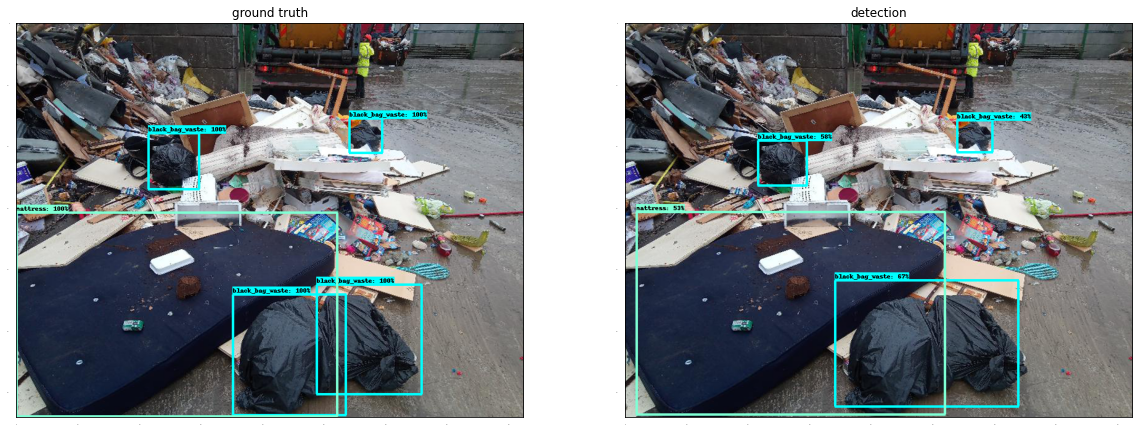

In [ ]:
plt.figure(figsize=(20, 10))
detection = detect(test_image_tensors[idx])

plt.subplot(1, 2, 1)

plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[idx],
      y_test_classes[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)
plt.title('ground truth')

plt.subplot(1, 2, 2)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)
plt.title('detection')

print(idx)
idx += 1

## mAP Block

## mAP - Train

In [ ]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(y_train_classes))):
  detection = detect(train_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.5)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


In [ ]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_train_boxes, 
                          y_train_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5,
                          suppress_output = False)

print(map)

print(sum(map)/num_classes)



bagged_waste: 727 annotations
223 / 231 correct detections 

black_bag_waste: 1185 annotations
730 / 803 correct detections 

mattress: 101 annotations
77 / 85 correct detections 

tyre_and_machine_track: 240 annotations
172 / 199 correct detections 

[0.3010941587807501, 0.5978174045890646, 0.698117471401701, 0.6759739151880331]
0.5682507374898872


## mAP - Test

In [ ]:
test_detected_boxes = []
test_detected_classes = []
test_detected_scores = []

for i in tqdm(range(len(x_test_np))):
  detection = detect(test_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  test_detected_boxes.append(detected_box)
  test_detected_classes.append(detected_class)
  test_detected_scores.append(detected_score)

In [ ]:
p, r, map = calculate_map(test_detected_boxes, 
                          test_detected_classes, 
                          test_detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5, 
                          suppress_output = False)

print(map)
print(f'mAP: {sum(map)/num_classes}')

bagged_waste: 34 annotations
10 / 12 correct detections 

black_bag_waste: 134 annotations
78 / 103 correct detections 

mattress: 6 annotations
3 / 4 correct detections 

tyre_and_machine_track: 7 annotations
4 / 5 correct detections 

[0.20009124862066038, 0.5256367248136757, 0.33333333333333337, 0.3547619047619047]
mAP: 0.35345580288239353


In [ ]:
  
  class_eval = 1
  length = len(detected_boxes)
  detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
  detected_classes_eval = [np.array([])]*length
  detected_scores_eval = [np.array([])]*length

  length = len(y_test_classes)
  gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
  gt_classes_eval = [np.array([])]*length


  for i, detected_class in enumerate(detected_classes):
    for j, Class in enumerate(detected_class):
      if Class == class_eval:
        detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_classes[i][j])
        detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_boxes[i][j]])
        detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_scores[i][j])
    if detected_boxes_eval[i].shape[0] == 1:
      detected_boxes_eval[i] = np.array([])
    else:
      detected_boxes_eval[i] = detected_boxes_eval[i][1:]

  for i, gt_class in enumerate(y_test_classes):
    for j, Class in enumerate(gt_class):
      if Class == class_eval:
        gt_classes_eval[i] = np.append(gt_classes_eval[i], y_test_classes[i][j])
        gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], y_test_boxes[i][j]])
    if gt_boxes_eval[i].shape[0] == 1:
      gt_boxes_eval[i] = np.array([])
    else:
      gt_boxes_eval[i] = gt_boxes_eval[i][1:]

pred_boxes = detected_boxes_eval
gt_boxes = gt_boxes_eval